In [7]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


In [2]:
class DiffusionForwardProcess:
    
    """
    
    Forward Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.betas = torch.linspace(beta_start, beta_end, num_time_steps)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bars = torch.sqrt(self.alpha_bars)
        self.sqrt_one_minus_alpha_bars = torch.sqrt(1 - self.alpha_bars)
        
    def add_noise(self, original, noise, t):
        
        """ Adds noise to a batch of original images at time-step t.
        
        :param original: Input Image Tensor
        :param noise: Random Noise Tensor sampled from Normal Dist N(0, 1)
        :param t: timestep of the forward process of shape -> (B, )
        
        Note: time-step t may differ for each image inside the batch.
        
        """
        
        sqrt_alpha_bar_t = self.sqrt_alpha_bars.to(original.device)[t]
        sqrt_one_minus_alpha_bar_t = self.sqrt_one_minus_alpha_bars.to(original.device)[t]
        
        # Broadcast to multiply with the original image.
        sqrt_alpha_bar_t = sqrt_alpha_bar_t[:, None, None, None]
        sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alpha_bar_t[:, None, None, None]
        
        # Return
        return (sqrt_alpha_bar_t * original) \
                           + \
               (sqrt_one_minus_alpha_bar_t * noise)

In [3]:
# Test
original = torch.randn(4, 1, 28, 28)
noise = torch.randn(4, 1, 28, 28)
t_steps = torch.randint(0, 1000, (4,)) 

# Forward Process
dfp = DiffusionForwardProcess()
out = dfp.add_noise(original, noise, t_steps)
out.shape

torch.Size([4, 1, 28, 28])

### Reverse process

In [62]:
class DiffusionReverseProcess:
    
    r"""
    
    Reverse Process class as described in the 
    paper "Denoising Diffusion Probabilistic Models"
    
    """
    
    def __init__(self, 
                 num_time_steps = 1000, 
                 beta_start = 1e-4, 
                 beta_end = 0.02
                ):
        
        # Precomputing beta, alpha, and alpha_bar for all t's.
        self.b = torch.linspace(beta_start, beta_end, num_time_steps) # b -> beta
        self.a = 1 - self.b # a -> alpha
        self.a_bar = torch.cumprod(self.a, dim=0) # a_bar = alpha_bar
        
    def sample_prev_timestep(self, xt, noise_pred, t):
        # Original Image Prediction at timestep t
        a_bar_t = self.a_bar.to(xt.device)[t][:, None, None, None]
        a_t = self.a.to(xt.device)[t][:, None, None, None]
        b_t = self.b.to(xt.device)[t][:, None, None, None]

        sqrt_one_minus_a_bar_t = torch.sqrt(1 - a_bar_t)
        sqrt_a_bar_t = torch.sqrt(a_bar_t)
        sqrt_a_t = torch.sqrt(a_t)

        x0 = (xt - sqrt_one_minus_a_bar_t * noise_pred) / sqrt_a_bar_t
        x0 = torch.clamp(x0, -1., 1.)

        # mean of x_(t-1)
        mean = (xt - (1 - a_t) * noise_pred / sqrt_one_minus_a_bar_t) / sqrt_a_t

        # only return mean
        if (t == 0).all():
            return mean, x0
        else:
            variance = ((1 - self.a_bar.to(xt.device)[t-1]) / (1 - a_bar_t.squeeze())) * b_t.squeeze()
            variance = variance[:, None, None, None]
            sigma = torch.sqrt(variance)
            z = torch.randn_like(xt).to(xt.device)
            return mean + sigma * z, x0

In [63]:
# Test
original = torch.randn(1, 1, 28, 28)
noise_pred = torch.randn(1, 1, 28, 28)
t = torch.randint(0, 1000, (1,)) 

# Forward Process
drp = DiffusionReverseProcess()
out, x0 = drp.sample_prev_timestep(original, noise_pred, t)
out.shape

torch.Size([1, 1, 28, 28])



####  U-net

In [48]:
class ScoreNetwork(nn.Module):
    def __init__(self):
        super(ScoreNetwork, self).__init__()
        nch = 2
        chs = [32, 64, 128, 256, 256]
        self._convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(2, chs[0], kernel_size=3, padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(chs[0], chs[1], kernel_size=3, padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(chs[1], chs[2], kernel_size=3, padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Conv2d(chs[2], chs[3], kernel_size=3, padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(chs[3], chs[4], kernel_size=3, padding=1),
                nn.LogSigmoid(),
            ),
        ])
        self._tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(chs[4], chs[3], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.ConvTranspose2d(chs[3]*2, chs[2], kernel_size=3, stride=2, padding=1, output_padding=0),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.ConvTranspose2d(chs[2]*2, chs[1], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.ConvTranspose2d(chs[1]*2, chs[0], kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.LogSigmoid(),
            ),
            nn.Sequential(
                nn.Conv2d(chs[0]*2, chs[0], kernel_size=3, padding=1),
                nn.LogSigmoid(),
                nn.Conv2d(chs[0], 1, kernel_size=3, padding=1),
            ),
        ])

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        # x: (B, 1, 28, 28), t: (B,)
        tt = t.float() / t.max()
        tt = tt[:, None, None, None].expand(-1, 1, x.shape[2], x.shape[3])
        x2t = torch.cat((x, tt), dim=1)  # Concatenate along channel dimension
        signal = x2t
        signals = []
        for i, conv in enumerate(self._convs):
            signal = conv(signal)
            if i < len(self._convs) - 1:
                signals.append(signal)
        for i, tconv in enumerate(self._tconvs):
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=1)
                signal = tconv(signal)
        return signal  # Output shape: (B, 1, 28, 28)

# Now, let's test the ScoreNetwork with a dummy MNIST dataset
if __name__ == "__main__":
    # Create a dummy MNIST dataset
    batch_size = 4
    x = torch.randn(batch_size, 1, 28, 28)  # Dummy images
    t_steps = torch.randint(0, 1000, (batch_size,))  # Random time steps

    # Initialize the ScoreNetwork
    model = ScoreNetwork()

        # Forward pass
    output = model(x, t_steps)
    print(f"Output shape: {output.shape}")  # Should be (B, 1, 28, 28)

Output shape: torch.Size([4, 1, 28, 28])


## Training

#### Dataset

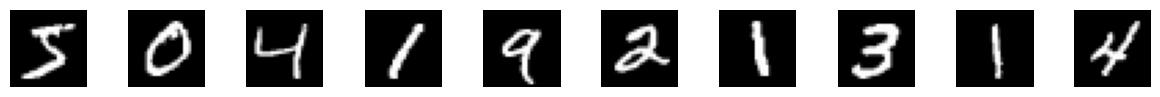

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [49]:
#%%
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from tqdm import tqdm




#%%
# Apply transformations to convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor()
])

# Update dataset to use the transform
dataset = MNIST(root='./data', train=True, download=True, transform=transform)

toPIL = transforms.ToPILImage()

# display 10 images from the dataset
fig, axes = plt.subplots(1, 10, figsize=(15, 1))
for i in range(10):
    image, label = dataset[i]
    axes[i].imshow(toPIL(image), cmap='gray')
    axes[i].axis('off')
plt.show()

# Create a simple DataLoader from the MNIST dataset
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Example of iterating through the DataLoader
for images, labels in dataloader:
    print(images.shape, labels.shape)
    break


#%%



In [50]:
# Load MNIST dataset from torch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [65]:
class CustomMnistDataset(Dataset):
    """
    Custom MNIST dataset that normalizes images to [-1, 1].
    """
    def __init__(self, train=True):
        super(CustomMnistDataset, self).__init__()
        self.mnist_data = MNIST(root='./data', train=train, download=True, transform=None)
        self.transform = transforms.Compose([
        transforms.ToTensor(),  # [0, 1]
        transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
])


    def __len__(self):
        return len(self.mnist_data)

    def __getitem__(self, index):
        img, _ = self.mnist_data[index]
        img = self.transform(img)
        return img

In [64]:
class CONFIG:
    model_path = 'ddpm_score_network.pth'
    num_epochs = 50
    lr = 1e-4
    num_timesteps = 1000
    batch_size = 64
    img_size = 28
    in_channels = 1
    num_img_to_generate = 256

In [66]:
# Training Function
def train(cfg):
    # Dataset and Dataloader
    mnist_ds = CustomMnistDataset(train=True)
    mnist_dl = DataLoader(mnist_ds, batch_size=cfg.batch_size, shuffle=True)

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')

    # Initiate Model
    model = ScoreNetwork().to(device)

    # Initialize Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)
    criterion = torch.nn.MSELoss()

    # Diffusion Forward Process to add noise
    dfp = DiffusionForwardProcess()

    # Best Loss
    best_eval_loss = float('inf')

    # Train
    for epoch in range(cfg.num_epochs):

        # For Loss Tracking
        losses = []

        # Set model to train mode
        model.train()

        # Loop over dataloader
        for imgs in tqdm(mnist_dl):
            imgs = imgs.to(device)

            # Generate noise and timestamps
            noise = torch.randn_like(imgs).to(device)
            t = torch.randint(0, cfg.num_timesteps, (imgs.shape[0],)).to(device)

            # Add noise to the images using Forward Process
            noisy_imgs = dfp.add_noise(imgs, noise, t)

            # Avoid Gradient Accumulation
            optimizer.zero_grad()

            # Predict noise using ScoreNetwork
            noise_pred = model(noisy_imgs, t)

            # Calculate Loss
            loss = criterion(noise_pred, noise)
            losses.append(loss.item())

            # Backprop + Update model params
            loss.backward()
            optimizer.step()

        # Mean Loss
        mean_epoch_loss = np.mean(losses)

        # Display
        print('Epoch:{} | Loss : {:.4f}'.format(
            epoch + 1,
            mean_epoch_loss,
        ))

        # Save based on train-loss
        if mean_epoch_loss < best_eval_loss:
            best_eval_loss = mean_epoch_loss
            torch.save(model.state_dict(), cfg.model_path)

    print(f'Done training.....')

In [67]:
# Run the Training
cfg = CONFIG()
train(cfg)

Device: cuda



100%|██████████| 938/938 [00:16<00:00, 55.61it/s]


Epoch:1 | Loss : 0.2893


100%|██████████| 938/938 [00:31<00:00, 29.32it/s]


Epoch:2 | Loss : 0.1730


100%|██████████| 938/938 [00:16<00:00, 55.72it/s]


Epoch:3 | Loss : 0.1529


100%|██████████| 938/938 [00:17<00:00, 54.09it/s]


Epoch:4 | Loss : 0.1398


100%|██████████| 938/938 [00:17<00:00, 53.10it/s]


Epoch:5 | Loss : 0.1139


100%|██████████| 938/938 [00:17<00:00, 53.96it/s]


Epoch:6 | Loss : 0.0904


100%|██████████| 938/938 [00:30<00:00, 30.69it/s]


Epoch:7 | Loss : 0.0802


100%|██████████| 938/938 [00:19<00:00, 47.49it/s]


Epoch:8 | Loss : 0.0722


100%|██████████| 938/938 [00:17<00:00, 52.54it/s]


Epoch:9 | Loss : 0.0676


100%|██████████| 938/938 [00:18<00:00, 49.90it/s]


Epoch:10 | Loss : 0.0630


100%|██████████| 938/938 [00:30<00:00, 30.48it/s]


Epoch:11 | Loss : 0.0597


100%|██████████| 938/938 [00:28<00:00, 32.49it/s]


Epoch:12 | Loss : 0.0568


100%|██████████| 938/938 [00:31<00:00, 29.45it/s]


Epoch:13 | Loss : 0.0558


100%|██████████| 938/938 [00:18<00:00, 52.07it/s]


Epoch:14 | Loss : 0.0548


100%|██████████| 938/938 [00:29<00:00, 31.74it/s]


Epoch:15 | Loss : 0.0532


100%|██████████| 938/938 [00:18<00:00, 49.48it/s]


Epoch:16 | Loss : 0.0524


100%|██████████| 938/938 [00:20<00:00, 46.52it/s]


Epoch:17 | Loss : 0.0519


100%|██████████| 938/938 [00:31<00:00, 29.60it/s]


Epoch:18 | Loss : 0.0509


100%|██████████| 938/938 [00:20<00:00, 46.47it/s]


Epoch:19 | Loss : 0.0500


100%|██████████| 938/938 [00:18<00:00, 49.69it/s]


Epoch:20 | Loss : 0.0491


100%|██████████| 938/938 [00:19<00:00, 48.15it/s]


Epoch:21 | Loss : 0.0480


100%|██████████| 938/938 [00:17<00:00, 52.63it/s]


Epoch:22 | Loss : 0.0483


100%|██████████| 938/938 [00:29<00:00, 31.48it/s]


Epoch:23 | Loss : 0.0479


100%|██████████| 938/938 [00:30<00:00, 31.11it/s]


Epoch:24 | Loss : 0.0468


100%|██████████| 938/938 [00:30<00:00, 30.80it/s]


Epoch:25 | Loss : 0.0468


100%|██████████| 938/938 [00:30<00:00, 30.98it/s]


Epoch:26 | Loss : 0.0460


100%|██████████| 938/938 [00:40<00:00, 22.88it/s]


Epoch:27 | Loss : 0.0454


100%|██████████| 938/938 [00:19<00:00, 47.37it/s]


Epoch:28 | Loss : 0.0453


100%|██████████| 938/938 [00:18<00:00, 50.32it/s]


Epoch:29 | Loss : 0.0442


100%|██████████| 938/938 [00:31<00:00, 29.97it/s]


Epoch:30 | Loss : 0.0446


100%|██████████| 938/938 [00:19<00:00, 47.21it/s]


Epoch:31 | Loss : 0.0439


100%|██████████| 938/938 [00:19<00:00, 47.48it/s]


Epoch:32 | Loss : 0.0435


100%|██████████| 938/938 [00:16<00:00, 55.45it/s]


Epoch:33 | Loss : 0.0439


100%|██████████| 938/938 [00:29<00:00, 31.87it/s]


Epoch:34 | Loss : 0.0434


100%|██████████| 938/938 [00:31<00:00, 29.92it/s]


Epoch:35 | Loss : 0.0430


100%|██████████| 938/938 [00:18<00:00, 51.52it/s]


Epoch:36 | Loss : 0.0427


100%|██████████| 938/938 [00:28<00:00, 32.37it/s]


Epoch:37 | Loss : 0.0433


100%|██████████| 938/938 [00:29<00:00, 31.93it/s]


Epoch:38 | Loss : 0.0423


100%|██████████| 938/938 [00:19<00:00, 48.71it/s]


Epoch:39 | Loss : 0.0429


100%|██████████| 938/938 [00:17<00:00, 53.39it/s]


Epoch:40 | Loss : 0.0418


100%|██████████| 938/938 [00:29<00:00, 31.48it/s]


Epoch:41 | Loss : 0.0422


100%|██████████| 938/938 [00:22<00:00, 41.43it/s]


Epoch:42 | Loss : 0.0421


100%|██████████| 938/938 [00:29<00:00, 31.53it/s]


Epoch:43 | Loss : 0.0413


100%|██████████| 938/938 [00:17<00:00, 53.46it/s]


Epoch:44 | Loss : 0.0410


100%|██████████| 938/938 [00:18<00:00, 50.72it/s]


Epoch:45 | Loss : 0.0409


100%|██████████| 938/938 [00:17<00:00, 52.92it/s]


Epoch:46 | Loss : 0.0405


100%|██████████| 938/938 [00:31<00:00, 30.18it/s]


Epoch:47 | Loss : 0.0408


100%|██████████| 938/938 [00:27<00:00, 34.32it/s]


Epoch:48 | Loss : 0.0410


100%|██████████| 938/938 [00:26<00:00, 36.03it/s]


Epoch:49 | Loss : 0.0398


100%|██████████| 938/938 [00:30<00:00, 30.37it/s]

Epoch:50 | Loss : 0.0405
Done training.....


**TO DO**: 
### Image Generation/Inference¶


C:\Users\Leuro\AppData\Local\Temp\ipykernel_2152\2759189622.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.model_path, map_location

Device: cuda



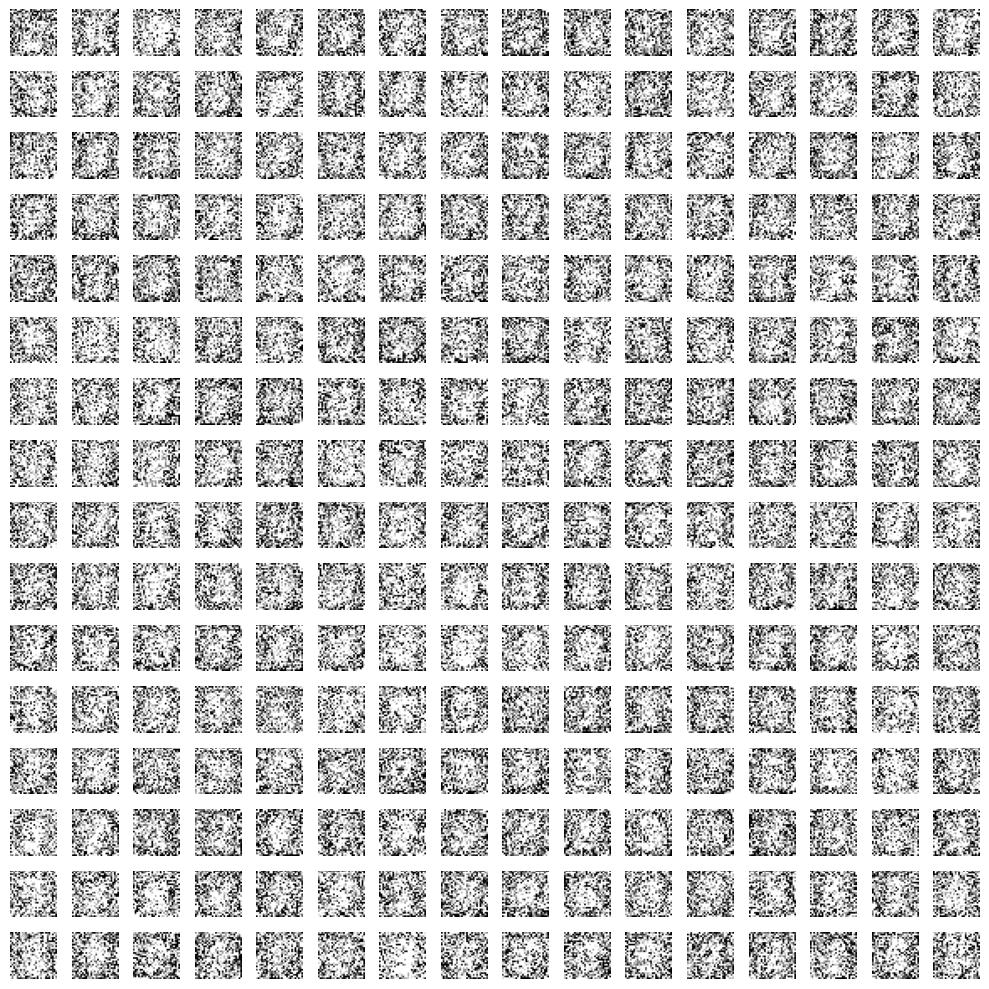

In [68]:
def generate_images(cfg):
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Device: {device}\n')

    # Load the trained model
    model = ScoreNetwork().to(device)
    model.load_state_dict(torch.load(cfg.model_path, map_location=device))
    model.eval()

    # Initialize the reverse diffusion process
    drp = DiffusionReverseProcess()

    # Starting from pure noise
    x_t = torch.randn(cfg.num_img_to_generate, 1, cfg.img_size, cfg.img_size).to(device)

    # Store generated images at each timestep for visualization (optional)
    generated_images = []

    # Loop from T down to 0
    with torch.no_grad():
        for t in reversed(range(cfg.num_timesteps)):
            t_batch = torch.full((cfg.num_img_to_generate,), t, device=device, dtype=torch.long)
            # Predict noise using the model
            noise_pred = model(x_t, t_batch)
            # Get x_{t-1} from x_t
            x_t, x0_pred = drp.sample_prev_timestep(x_t, noise_pred, t_batch)
            # Collect the final denoised image
            if t % (cfg.num_timesteps // 10) == 0 or t == 0:
                generated_images.append(x0_pred.cpu())

    # Concatenate all generated images
    generated_images = torch.cat(generated_images, dim=0)

    # Denormalize images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2
    generated_images = torch.clamp(generated_images, 0, 1)

    # Plot and save the generated images
    grid_size = int(cfg.num_img_to_generate ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        if idx < cfg.num_img_to_generate:
            img = generated_images[idx].squeeze(0)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.tight_layout()
    plt.show()

# %%
# Run the image generation
cfg = CONFIG()
generate_images(cfg)